<a href="https://colab.research.google.com/github/ric-colasanti/ASPIREColab/blob/main/OOPShiNetworkModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rnd
import networkx as nx
import matplotlib.pyplot as plt
import math
import requests

In [2]:
# drive.mount('/gdrive',force_remount=True)
# f = open('/gdrive/My Drive/NNMdata/selected_population.json',)
# selected_population = json.load(f) 
# f.close()

url = "https://ric-colasanti.github.io/ASPIREColab/Data/selected_population.json"
r = requests.get(url)
selected_population = r.json()

In [49]:
class PersonData:
    T_PA = 0.12
    T_EI = 0.07
    def __init__(self,person,key,data):
        self.person = person
        self.year = key
        self.age = data["age"]
        self.height = data["height"]/100 # error in data is 100 * 
        self.BW = data["weight"]
        self.BMI = self.BW/(self.height * self.height)
        self.EI = data["energy_intake"]
        self.EE = 0.0 # Energy expenditure
        self.PA = 0.0 # Physical activity
        self.Env = 1.0 # Environment
        if self.BMI<18.5:
            self.BMI_catagory = 1
        elif self.BMI>=18.5 and self.BMI<24:
            self.BMI_catagory = 2
        elif self.BMI>=24 and self.BMI<28:
            self.BMI_catagory = 3
        else:
            self.BMI_catagory = 4
        self.BEE = 0
        self.calc_BEE()

    def calc_BEE(self):
        if self.person.gender ==1:
            self.BEE = ((66.5 + 13.6 * self.BW + 500 * self.height - 6.8 * self.age) * 4186 / 1000000) 
        else:
            self.BEE = ((655.1 + 9.5 * self.BW + 180 * self.height - 4.1 * self.age)* 4186 / 1000000) 

    def diffuse_behavior(self):# the calculation of influence and EI/PA change
        inf_PA = 0
        inf_EI = 0
        temp = 0
        s  = 0
        inf_PA_Env = 0
        inf_EI_Env = 0

        for agent in self.person.linked:
            temp =  agent.d_2009.PA - self.PA
            s += temp
  
        inf_PA  = (1 / len(self.person.linked))  * s

        temp = 0
        s  = 0
        for agent in self.person.linked:
            temp  = agent.d_2009.EI - self.EI
            s += temp

        inf_EI  = (1 / len(self.person.linked))  * s

        if inf_PA >= 0:
            inf_PA_Env = inf_PA * self.Env
        else:
            inf_PA_Env = inf_PA / self.Env

        if inf_EI < 0:
            inf_EI_Env = inf_EI * self.Env
        else:
            inf_EI_Env = inf_EI / self.Env

        if (inf_PA_Env > 0) and (abs(inf_PA_Env) > PersonData.T_PA * self.PA):
            self.PA *= (1 + 0.05)
        if (inf_PA_Env < 0) and (abs(inf_PA_Env) > PersonData.T_PA * self.PA):
            self.PA *= (1 - 0.05)

        if (inf_EI_Env > 0) and (abs(inf_EI_Env) > PersonData.T_EI * self.EI):
            self.EI *= (1 + 0.05)
        if (inf_EI_Env < 0) and (abs(inf_EI_Env) > PersonData.T_EI * self.EI):
            self.EI *= (1 - 0.05) 
    
    def update(self):#the calculation of BW change
        EBI = 0
        self.EE = self.BEE + 0.1 * self.EI + self.PA
        EIB = 7 * (self.EI - self.EE) / 5
        self.BW += (EIB / (7 * math.log(self.BW + 1) + 5))
        self.calc_BEE()
  

class Person:
    def __init__(self,key,data):
        self.id = key
        self.gender = data["gender"]
        self.d_2009 = PersonData(self,"2009",data["2009"])
        self.d_2011 = PersonData(self,"2011",data["2011"])
        self.linked = []
        self.is_part = False
        self.can_choose = False
        self.xpos =rnd.random()
        self.ypos =rnd.random()

    def distance(self,agent):
        x_sqr = abs(self.xpos-agent.xpos)
        x_sqr*=x_sqr
        y_sqr = abs(self.ypos-agent.ypos)
        y_sqr*=y_sqr
        return math.sqrt(x_sqr*y_sqr)
    

        


In [50]:
class Population:
    def __init__(self,selected_population):
        
        self.persons = []
        self.npos ={}
        self.colors=[]

        self.graph = nx.Graph(directed=False)
        bcolors=["white","red","green","blue","yellow"]
        for key, person in selected_population.items():
            new_person = Person(key,person)
            self.graph.add_node(new_person.id)
            self.npos[new_person.id]=(new_person.xpos,new_person.ypos)
            self.colors.append(bcolors[new_person.d_2009.BMI_catagory])
            self.persons.append(new_person)  
         

    def makeLink(self,agent,choice):
        if self.graph.has_edge(agent.id,choice.id)==False:
            self.graph.add_edge(agent.id,choice.id)
            choice.linked.append(agent)
            agent.linked.append(choice)
        #choice.linked.append(agent)
        #     return True
        # return False
        

    def linkAgentTo(self,agent):
        
        candidate = list(filter(self.chosen_not_self_filter(agent),self.persons))  
        sink_agent = rnd.choice(candidate)
        if rnd.random()>0.2:
            candidate = list(filter(self.homophily_filter(agent),self.persons))
        choicelist =[]
        for agnt in candidate:
            for _ in range(len(agnt.linked)):
                choicelist.append(agnt)
        if len(choicelist)>0 :
            choice = rnd.choice(choicelist)
        else:
            choice = sink_agent

        self.makeLink(agent,choice)
            # if flag and choice in self.not_linked and len(choice.linked_to) >0:
            #     self.not_linked.remove(choice)
        
                
                


    def makeGraph(self,ld = 0.267):                
        i = 0
        while i < len(self.persons):
            linkable = list(filter(self.can_choose_filter(),self.persons))
            if (rnd.random()<=ld) and (len(linkable)>2):
                agent = rnd.choice(linkable)
                self.linkAgentTo(agent)
            else:
                not_linked = list(filter(self.not_chosen_filter(),self.persons))
                agent = rnd.choice(not_linked)
                agent.can_choose = True
                i+=1

        not_linked = list(filter(self.not_linked_to_filter(),self.persons))
        for agent in not_linked:
            self.linkAgentTo(agent)   


    def  homophily_filter(self,agent):
        agent = agent
        def infun(x):
            d = x.d_2009
            a_d = agent.d_2009
            if x.can_choose == False:
                return False
            if x == agent:
                return False
            if (d.BMI_catagory == a_d.BMI_catagory ) and (x.gender == agent.gender) and (abs(d.age-a_d.age)<4):
                return True
            elif (x.gender == agent.gender) and (abs(d.age-a_d.age)<4) and (agent.distance(x)<0.2):
                return True
            elif (x.gender == agent.gender) and (d.BMI_catagory == a_d.BMI_catagory) and (agent.distance(x)<0.2):
                return True
            elif (abs(d.age-a_d.age)<4) and (d.BMI_catagory == a_d.BMI_catagory) and (agent.distance(x)<0.2):
                return True
            else:
                return False
        return infun

      

    def not_linked_to_filter(self):  
        def infun(x):
            if len(x.linked) ==0:
                return True
            #if len(x.linked_from) == 0:
            #    return True
            return False
        return infun 

    def chosen_not_self_filter(self,agent):
        agent = agent
        def infun(x):
            if x == agent:
                return False
            elif x.can_choose:
                return True
            return False
        return infun


    def not_chosen_filter(self):
        def infun(x):
            if x.can_choose:
                return False
            return True
        return infun



    def can_choose_filter(self):  
        def infun(x):
            if x.can_choose and x.is_part:
                return True
            return False
        return infun


    def run(self):
        for day in range(365*2):
            if day % 7 == 0:
                for person in self.persons:
                    person.d_2009.diffuse_behavior()
                    person.d_2009.update()

In [57]:
population = Population(selected_population)
population.makeGraph()

8198.98798091239
8078.622066192078
8927.670747725842
7515.304285394848
9131.104580276738
8176.393865825952
7910.523728020938
8371.879914105326
8875.373515150313
7517.976011959679
8231.766266635714
9058.489425986596
8342.44209756314
8938.356097806594
7906.866832680224
10134.206270890272
8876.904162714984
7753.283324667973
8512.601569800137
7417.909999827532
7843.566055890562
7044.9430769849505
8658.55907225813
7953.259719020165
8620.050974200909
8417.511972766353
7583.174706839664
9688.903060162344
8586.735660447062
8234.030718699796
8718.34938554971
8547.64171534893
8006.370674556756
8105.5306244407475
7407.558505793113
8190.844810557545
8315.19110203395
10701.956765335897
7844.6649705206055
9359.16804857451
8334.08458130398
8309.4851996919
8010.625953281176
8396.902145825521
7680.574703556023
7280.144414398163
8969.872324430322
8136.007594160109
9193.255300351813
8122.486277167975
8124.589638294286
9427.488406462799
8313.120383569221
7957.307801444878
8778.499540611383
7622.3440541124

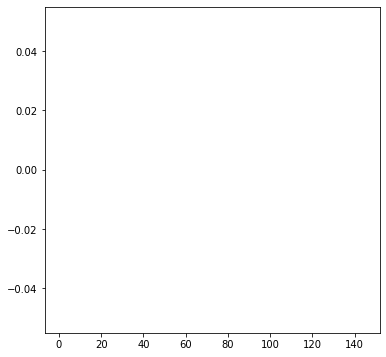

In [56]:
weights2009 = []
weights2011calc = []
for person in population.persons:
    weights2009.append(person.d_2009.BW)    
weights_np_2009 = np.array(weights2009)
population.run()
for person in population.persons:
    print(person.d_2009.BW)
    weights2011calc.append(person.d_2009.BW)    
weights_np_2011calc = np.array(weights2011calc)
bins = [x for x in range(0,150,5)]
plt.rcParams["figure.figsize"] = (6,6)
plt.hist([weights_np_2009,weights_np_2011calc] ,bins=bins)
plt.show()